In [1]:
import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sys

path_tools = '/home1/datahome/ljessel/'  # path to the python script directory
sys.path.append(path_tools)
from python_scripts.find_mean_inc_angle import find_mean_incidence_angle

# 1) loading the dataframes & merging into one single dataframe

### Here, the data is for all Sentinel1-B L1C_4.1 files 

In [2]:
# Loading files
fns_csv=[]

base_path = '/home1/datawork/ljessel/l1c_converted/4.1/'
safe_pattern = 'S1B_IW_XSP__1SDV_*.SAFE/'   # for all S1A data
burst_type_pattern = 'intraburst'   
#burst_type_pattern = 'interburst'

csv_polar_pattern = '/*vv*.csv'
#csv_polar_pattern = '/*vh*.csv'
#csv_polar_pattern = '/*.csv'

safes = glob.glob(base_path+safe_pattern+burst_type_pattern)  # we retrieve all the SAFE files we want
print('number of SAFE files : '+str(len(safes)))

for safe in safes :
    fns_csv += glob.glob(safe+csv_polar_pattern)      # we retrieve the .csv files from the preselected .Safe files 
print('number of csv files : '+str(len(fns_csv)))


### merging it into one single dataframe 
df_tot = pd.read_csv(fns_csv[0])
for csv_file in fns_csv[1:]:   
    df = pd.read_csv(csv_file)
    df_tot = pd.concat([df, df_tot], ignore_index=True)
    
df_tot

number of SAFE files : 4076
number of csv files : 11500


,sigma0_filt,incidence,nesz_filt,ground_heading,land_flag,uwnd,vwnd,U10,V10,normalized_variance_filt,longitude,latitude,macs_Im_lambda_max=50.0,macs_Re_lambda_max=50.0,file_path
0,0.014879,36.729164,0.002618,-169.24579,0,-2.426171,-6.442220,-3.577550,-5.979798,1.202405,7.079135,54.267754,-0.002851,0.075286,/home/datawork-cersat-public/cache/project/sar...
1,0.012748,37.812454,0.001852,-169.46527,0,-2.760316,-6.247069,-2.879708,-5.389998,1.210081,6.815118,54.296090,-0.000099,0.081352,/home/datawork-cersat-public/cache/project/sar...
2,0.012046,38.871353,0.001600,-169.68478,0,-3.130633,-5.909240,-2.234767,-5.158987,1.212661,6.550668,54.323860,-0.003402,0.087638,/home/datawork-cersat-public/cache/project/sar...
3,0.011271,39.905987,0.001722,-169.90433,0,-3.319036,-5.910591,-1.777785,-5.367301,1.224292,6.285901,54.351044,-0.001020,0.089556,/home/datawork-cersat-public/cache/project/sar...
4,0.012014,40.916730,0.002352,-170.12387,0,-3.473148,-5.958917,-1.223289,-6.280388,1.238181,6.020821,54.377644,0.002273,0.077929,/home/datawork-cersat-public/cache/project/sar...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453804,0.003261,35.096000,0.002844,-168.45007,0,NaN,NaN,3.155244,-1.074479,1.469159,17.198938,58.530770,-0.004089,0.016554,/home/datawork-cersat-public/cache/project/sar...
453805,0.005698,31.593813,0.003499,-167.70720,0,3.298443,0.821070,3.309536,1.186993,1.491469,18.013525,58.275110,-0.002192,0.017053,/home/datawork-cersat-public/cache/project/sar...
453806,0.008292,32.788180,0.003137,-167.96074,0,3.284911,0.667811,3.535650,0.192753,1.527969,17.721899,58.307390,0.003706,0.015660,/home/datawork-cersat-public/cache/project/sar...
453807,0.003202,33.957066,0.002915,-168.21585,0,3.185295,0.468747,3.501364,-1.267716,1.423299,17.429747,58.339000,0.004680,0.015132,/home/datawork-cersat-public/cache/project/sar...


In [3]:
### Computation of others variables from the ones that are in the csv
u = df_tot['U10']  
v = df_tot['V10']
df_tot['Wspeed'] = np.sqrt(u**2 + v**2)                                # wind speed norm taken from ECMWF model
df_tot['wdir'] = np.mod(180+(180/np.pi)*np.arctan2(u,v),360)           # wind direction taken from the north 
df_tot['wdir_az'] = ((df_tot['wdir']-df_tot['ground_heading']-90)%360) # wind direction brought back to the antenna's frame of reference 
df_tot['sigma0_dB_filt'] = 10*np.log10(df_tot['sigma0_filt'])          # sigma0 filtered in dB


### Selection of the variables of interest for the MACS analysis 
df = df_tot[['macs_Im_lambda_max=50.0', 'sigma0_dB_filt','incidence', 'Wspeed', 'wdir_az']]

az_wdir = df['wdir_az']
macs_Im = df['macs_Im_lambda_max=50.0']
NRCS = df['sigma0_dB_filt']
incidence = df['incidence']
wnd_spd = df['Wspeed']

df

/home1/datawork/ljessel/micromamba-env/xsar_env_py3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,macs_Im_lambda_max=50.0,sigma0_dB_filt,incidence,Wspeed,wdir_az
0,-0.002851,-18.274259,36.729164,6.968274,110.136719
1,-0.000099,-18.945618,37.812454,6.111039,107.579467
2,-0.003402,-19.191544,38.871353,5.622218,103.106050
3,-0.001020,-19.480251,39.905987,5.654064,98.230499
4,0.002273,-19.203233,40.916730,6.398414,91.145894
...,...,...,...,...,...
453804,-0.004089,-24.867109,35.096000,3.333177,7.255698
453805,-0.002192,-22.442994,31.593813,3.515961,327.976396
453806,0.003706,-20.813471,32.788180,3.540900,344.840239
453807,0.004680,-24.946428,33.957066,3.723795,8.119319


## 1.1) verification plot 

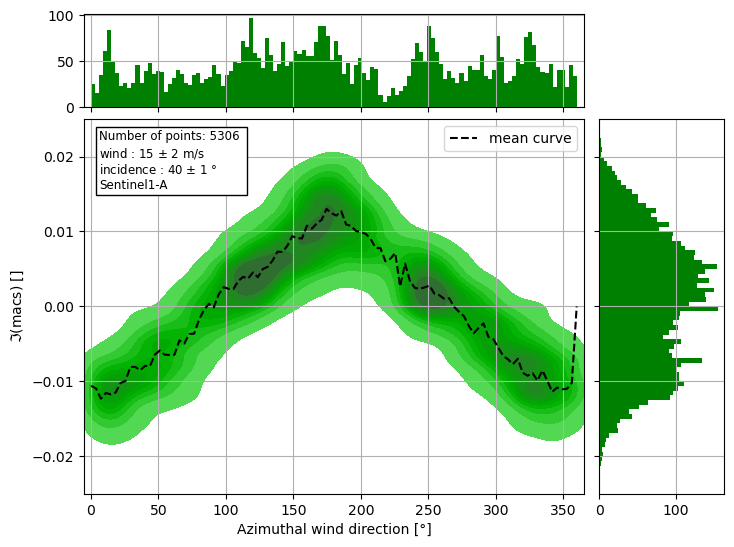

In [4]:
mask_verif = (wnd_spd.values > 13) & (wnd_spd.values < 17) & (incidence.values > 39) & (incidence.values < 41)  # selection of a range of 2 m/s around 15m/s wind speed and a range of 1° around 40° of incidence
NRCS_verif = NRCS[mask_verif]                          
macs_Im_verif = macs_Im[mask_verif]                    
az_wdir_verif = az_wdir.loc[NRCS_verif.index]       # selection of the az_wdir corresponding to the range 
az_wdir_sel = az_wdir_verif



#### Figure ####

# plot figure
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

sns.kdeplot(x=az_wdir_verif, y=macs_Im_verif, color='green', fill=True, bw_adjust=.5, ax=ax)
ax.set_xlim(-5,365)
ymax = 0.025
ax.set_ylim(-ymax, ymax)
ax.set_xlabel('Azimuthal wind direction [°]')
ax.set_ylabel('$\Im$(macs) []')
ax.grid()


## density plots 
binwidth = 1

x_bins = np.arange(0,360 + binwidth, binwidth*3)
ax_histx.hist(az_wdir_verif,bins=x_bins, color='green')
ax_histx.grid()

y_bins = np.arange(-ymax, ymax , binwidth*ymax**2)
ax_histy.hist(macs_Im_verif, bins=y_bins, color='green', orientation='horizontal')
ax_histy.grid()

txt_str = 'Number of points: %d \nwind : 15 $\pm$ 2 m/s \nincidence : 40 $\pm$ 1 ° \nSentinel1-A' % (len(macs_Im_verif))
props = dict(boxstyle = 'square', facecolor = 'white')
ax.text(0.03, 0.97, txt_str, transform = ax.transAxes, fontsize = 8.5, verticalalignment = 'top', bbox = props)


# mean curve calculation
Imacs_sel = macs_Im_verif
az_wdir_sel_mean = np.linspace(min(az_wdir_sel), max(az_wdir_sel), 100) # settings points for the mean curve
Imacs_mean = np.zeros_like(az_wdir_sel_mean)                            # Initialise mean s0 values
bin_edges = np.linspace(min(az_wdir_sel), max(az_wdir_sel), 100)        # discretize the data in 100 bins 
for i in range(len(bin_edges) - 1):
    mask = (az_wdir_sel >= bin_edges[i]) & (az_wdir_sel < bin_edges[i+1])     # Mask to selects the points in the bin
    Imacs_mean[i] = np.mean(Imacs_sel[mask]) if np.sum(mask) > 0 else np.nan  # Calculation of the Imacs mean value in the bin
ax.plot(az_wdir_sel_mean, Imacs_mean, color='black', label='mean curve', linestyle='--' )     # plot the mean curve

ax.legend()
#plt.savefig('/home1/datahome/ljessel/Plots/MACS_analysis/all_S1A/verif_plots_imacs.png')


## 1.2) Discretisation of incidence angles at 6 m/s with the Find_peaks function

In [4]:
## we retrieve the part of the dataframe were the wind is around 6 m/s (most represented value)
df_6ms = df[(df['Wspeed'] > 4) & (df['Wspeed'] < 8)].sort_values(by='incidence')

az_wdir_6ms = df_6ms['wdir_az']
macs_Im_6ms = df_6ms['macs_Im_lambda_max=50.0']
NRCS_6ms = df_6ms['sigma0_dB_filt']
incidence_6ms = df_6ms['incidence']

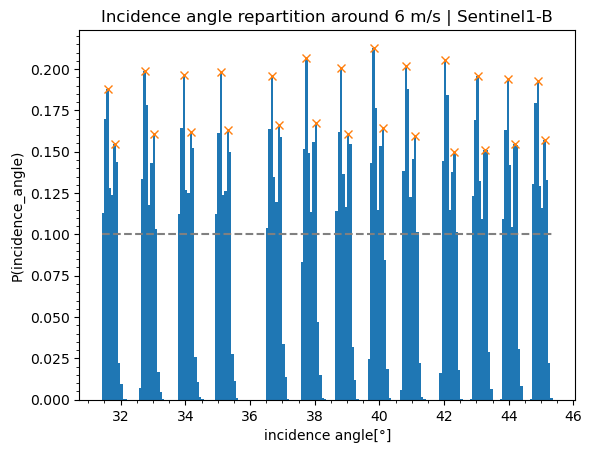

array([  2,   5,  18,  22,  35,  38,  51,  54,  73,  76,  88,  92, 103,
       106, 117, 121, 131, 135, 148, 152, 162, 165, 175, 178, 188, 191])

26

array([31.56074645, 31.77527862, 32.70491802, 32.99096091, 33.92060031,
       34.13513248, 35.06477188, 35.27930405, 36.63800778, 36.85253995,
       37.71066863, 37.99671152, 38.78332948, 38.99786165, 39.7844796 ,
       40.07052249, 40.78562972, 41.07167262, 42.00131202, 42.28735491,
       43.00246214, 43.21699431, 43.93210154, 44.14663371, 44.86174094,
       45.07627311])

[31.668012530769232,
 32.84793946153846,
 34.02786639230769,
 35.172037961538464,
 36.74527386923077,
 37.85369007692308,
 38.89059556153846,
 39.92750104615385,
 40.92865116923077,
 42.14433346153846,
 43.10972822307693,
 44.03936762307693,
 44.96900702307693]

13

In [18]:
from scipy.signal import find_peaks

## Search of the peaks 
hist, bins = np.histogram(incidence_6ms, bins=195, density=True)
height = 0.1
peaks, _ = find_peaks(hist, height=height)
bin_centers = 0.5 * (bins[:-1] + bins[1:])   # Use of intervals centers as x for plt.plot()

## Plot
plt.hist(incidence_6ms, bins=195, density=True)
plt.plot(bin_centers[peaks], hist[peaks], "x")
plt.hlines(height,np.min(bins), np.max(bins), linestyles="dashed", color="gray")
plt.xlabel('incidence angle[°]')
plt.ylabel('P(incidence_angle)')
plt.title('Incidence angle repartition around 6 m/s | Sentinel1-B')
plt.minorticks_on()
#plt.savefig('/home1/datahome/ljessel/Plots/MACS_analysis/all_S1B/inc_angle_histo.png')
plt.show()

#display(hist, bins)
display(peaks, len(peaks), bins[peaks])


### computation of mean_incidence_angle
mean_iangle= find_mean_incidence_angle(bins[peaks], gap=0.5)
mean_iangle_iw1 = mean_iangle[:4]
mean_iangle_iw2 = mean_iangle[4:9]
mean_iangle_iw3 = mean_iangle[9:]
display(mean_iangle, len(mean_iangle))

# 2) Setting different wind speed ranges and the incidence angles / Imacs values associated

In [13]:
wnd_spd_7ms = wnd_spd[(wnd_spd > 6) & (wnd_spd < 8)]
wnd_spd_10ms = wnd_spd[(wnd_spd > 9) & (wnd_spd < 11)]
wnd_spd_14ms = wnd_spd[(wnd_spd > 13) & (wnd_spd < 15)]
#wnd_spd_20ms = wnd_spd[(wnd_spd > 18) & (wnd_spd < 22)]

#display(wnd_spd_5ms, wnd_spd_5ms.index)
inc_tot =[incidence.loc[wnd_spd_7ms.index],incidence.loc[wnd_spd_10ms.index],incidence.loc[wnd_spd_14ms.index]]
macs_Im_tot = [macs_Im.loc[wnd_spd_7ms.index],macs_Im.loc[wnd_spd_10ms.index],macs_Im.loc[wnd_spd_14ms.index]]

In [14]:
macs_Im_tot

[0        -0.002851
 1        -0.000099
 4         0.002273
 8        -0.004007
 9        -0.003414
             ...   
 453387   -0.000873
 453389   -0.004776
 453390   -0.001969
 453393   -0.000856
 453664   -0.023689
 Name: macs_Im_lambda_max=50.0, Length: 87093, dtype: float64,
 24        0.001581
 29             NaN
 34             NaN
 46       -0.000557
 47       -0.002066
             ...   
 453622    0.009659
 453623    0.007116
 453624    0.005328
 453625    0.011821
 453628    0.013254
 Name: macs_Im_lambda_max=50.0, Length: 57421, dtype: float64,
 2063     -0.000685
 2064     -0.006220
 2065     -0.011446
 2066     -0.009097
 2067     -0.009824
             ...   
 453614    0.008737
 453616    0.008732
 453617    0.010008
 453618    0.007719
 453619    0.011135
 Name: macs_Im_lambda_max=50.0, Length: 21383, dtype: float64]

# 3) Plot New Generation (N-G) 

In [8]:
Imacs_sel = macs_Im_tot[2][(inc_tot[2] > mean_iangle_iw1[2]-1) & (inc_tot[2] < mean_iangle_iw1[2]+1)].dropna()  # selection of a range of 1° around one mean incidence angle and without NaN values
Imacs_sel = Imacs_sel[Imacs_sel !=0]        # selection of non nul values
az_wdir_sel = az_wdir.loc[Imacs_sel.index]  # selection of azimutal direction corresponding to the Imacs values selected 


# Create a new dataframe to duplicate data from the left (300 --> 0)
Imacs_before = Imacs_sel[az_wdir_sel >= 300]
az_wdir_before = az_wdir_sel[az_wdir_sel >= 300]
az_wdir_before -= 360        # modify the azimutal wind direction to get into the [-60 - 0] range  


# Create a new dataframe to duplicate data from the right (360 --> 60)
Imacs_after = Imacs_sel[az_wdir_sel <= 60].copy()
az_wdir_after = az_wdir_sel[az_wdir_sel <= 60]
az_wdir_after += 360         # modify the azimutal wind direction to get into the [360 - 60] range  


# Add the two duplicated datas to the original dataframe
imacs_ext = pd.concat([Imacs_before, Imacs_sel, Imacs_after])
az_wdir_ext = pd.concat([az_wdir_before, az_wdir_sel, az_wdir_after])

print(len(imacs_ext), len(Imacs_before), len(Imacs_after), len(Imacs_sel))

4570 558 486 3526


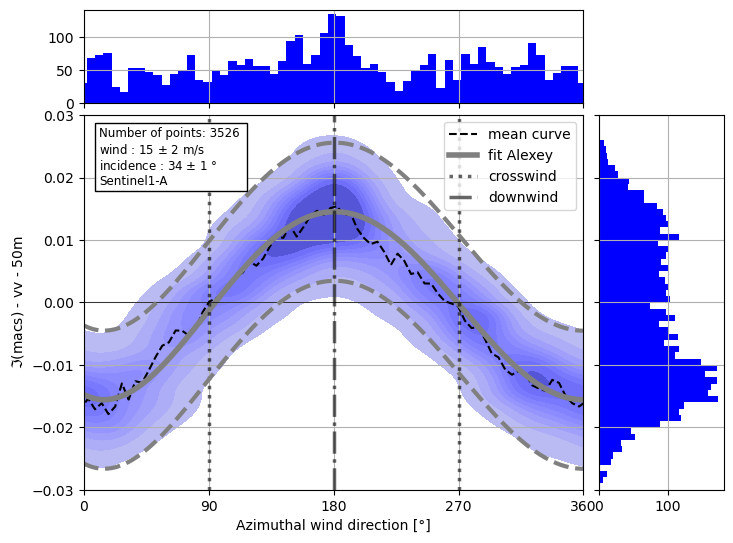

In [38]:
### plot figure ###

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

#ax.scatter(az_wdir_ext ,imacs_ext, color='blue', label='Sentinel-1A')
sns.kdeplot(x=az_wdir_ext, y=imacs_ext, color='blue', fill=True, bw_adjust=.5, ax=ax)
ymax = 0.030
ax.set_xticks([0,90,180,270,360])
ax.set_xlim(0,360)
ax.set_ylim(-ymax, ymax)
ax.set_xlabel('Azimuthal wind direction [°]')
ax.set_ylabel('$\Im$(macs) - vv - 50m')
ax.grid()


### density plots 
binwidth = 1

x_bins = np.arange(-70,420 + binwidth, binwidth*6)
ax_histx.hist(az_wdir_ext,bins=x_bins, color='blue')
ax_histx.grid()

y_bins = np.arange(-ymax, ymax , binwidth*ymax/30)
ax_histy.hist(imacs_ext, bins=y_bins, color='blue', orientation='horizontal')
ax_histy.grid()

txt_str = 'Number of points: %d \nwind : 15 $\pm$ 2 m/s \nincidence : %d $\pm$ 1 ° \nSentinel1-A' % (len(Imacs_sel), float(mean_iangle_iw1[2]))
props = dict(boxstyle = 'square', facecolor = 'white')
ax.text(0.03, 0.97, txt_str, transform = ax.transAxes, fontsize = 8.5, verticalalignment = 'top', bbox = props)


### mean curve calculation
az_wdir_sel_mean = np.linspace(min(az_wdir_ext), max(az_wdir_ext), 100) # settings points for the mean curve
Imacs_mean = np.zeros_like(az_wdir_sel_mean)                            # Initialise mean s0 values
bin_edges = np.linspace(min(az_wdir_ext), max(az_wdir_ext), 100)        # discretize the data in 100 bins 
for i in range(len(bin_edges) - 1):
    mask = (az_wdir_ext >= bin_edges[i]) & (az_wdir_ext < bin_edges[i+1])     # Mask to selects the points in the bin
    Imacs_mean[i] = np.mean(imacs_ext[mask]) if np.sum(mask) > 0 else np.nan  # Calculation of the Imacs mean value in the bin
ax.plot(az_wdir_sel_mean, Imacs_mean, color='black', label='mean curve', linestyle='--' )     # plot the mean curve


### Alexey fit curve 
def imacs_fit(alpha, u, phi):    # alpha: incidence angle, u: wind speed, phi: azimuth
    alpha = np.deg2rad(alpha)
    phi = np.deg2rad(phi)
    fit = ((0.07271781 / np.sin(np.sinc(np.exp(1/alpha)) + alpha)) *
           ((np.cos(phi - ((np.sinc(np.tan(alpha)) * np.sin(u ** 0.7317495)) / np.exp(phi))) *
             (4.593332 - (u + np.tan((np.cos(phi) * np.sin(0.4504337 - np.sin(u / np.exp(np.cos(alpha)))))
                                     +  0.18788569)))) - 0.17755319))
    return fit/100

#imacs_fit_alexey = imacs_fit(inc_tot[2].loc[az_wdir_ext.index], wnd_spd_15ms.loc[az_wdir_ext.index], az_wdir_ext.sort_values()) 
imacs_fit_alexey = imacs_fit(34, 15, az_wdir_ext.sort_values()) 
ax.plot(az_wdir_ext.sort_values(), imacs_fit_alexey, color='gray', label='fit Alexey', lw=4)     # plot the fit curve

ax.hlines(0,-70,420, color='black', lw=0.5) 
ax.vlines([90,270], -ymax, ymax, color='black', label='crosswind', linestyles="dotted", alpha=0.6, lw=2.5)
#ax.vlines([0,360], -ymax, ymax, color='black', label='upwind', alpha=0.6, lw=2.5)
ax.vlines(180, -ymax, ymax, color='black', label='downwind', linestyles="dashdot", alpha=0.6, lw=2.5)

imacs_fit_alexey_std = imacs_fit_alexey.std() 
ax.plot(az_wdir_ext.sort_values(), imacs_fit_alexey + imacs_fit_alexey_std , color='gray', ls='--', lw=3)     # plot the fit curve
ax.plot(az_wdir_ext.sort_values(), imacs_fit_alexey - imacs_fit_alexey_std , color='gray', ls='--', lw=3)

ax.legend()
#plt.savefig('/home1/datahome/ljessel/Plots/MACS_analysis/all_S1A/verif_plots_imacs.png')

## 3.2) Filtering around Alexey GMF 

In [15]:
def imacs_fit(alpha, u, phi):    # alpha: incidence angle, u: wind speed, phi: azimuth
    alpha = np.deg2rad(alpha)
    phi = np.deg2rad(phi)
    fit = ((0.07271781 / np.sin(np.sinc(np.exp(1/alpha)) + alpha)) *
           ((np.cos(phi - ((np.sinc(np.tan(alpha)) * np.sin(u ** 0.7317495)) / np.exp(phi))) *
             (4.593332 - (u + np.tan((np.cos(phi) * np.sin(0.4504337 - np.sin(u / np.exp(np.cos(alpha)))))
                                     +  0.18788569)))) - 0.17755319))
    return fit/100

In [16]:
def mean_curve_calc(az_wdir, imacs):
    # new bin setting
    bin_edges = np.arange(0, 361, 5)  # Bins every 5 degrees
    bin_centers = bin_edges + 5 / 2   # Centre of each bin
    bin_centers = bin_centers[:-1]    # Del the last element to keep the same length as bin_edges

    Imacs_mean = np.zeros_like(bin_centers)    # Initialise mean Imacs values

    for i in range(len(bin_centers)):
        mask = (az_wdir >= bin_centers[i] - 5) & (az_wdir < bin_centers[i] + 5)     # Mask to selects the points in the bin
        Imacs_mean[i] = np.mean(imacs[mask]) if np.sum(mask) > 0 else np.nan  # Calculation of the Imacs mean value in the bin
    #ax.plot(bin_centers, Imacs_mean, color='black', label='mean curve', linestyle='--' )     # plot the mean curve

## 3.3) Others inc and wind speed

### 3.3.2) 10m/s

#### 3.3.2.1) IW1 : 33° 

In [17]:
Imacs_sel = macs_Im_tot[1][(inc_tot[1] > mean_iangle_iw1[1]-1) & (inc_tot[1] < mean_iangle_iw1[1]+1)]  # Imacs values selection by wind speed and in a range of 1° around one mean incidence angle
Imacs_sel = Imacs_sel[Imacs_sel !=0].dropna()      # selection of non NaN and non nul values
az_wdir_sel = az_wdir.loc[Imacs_sel.index]         # selection of azimutal direction corresponding to the Imacs values selected 

### Imacs_fit Alexey
imacs_fit_alexey = imacs_fit(mean_iangle_iw1[1], 10, az_wdir_sel) 
imacs_fit_alexey_std = imacs_fit_alexey.std() 

print(mean_iangle_iw1[1])

### Filtering : Selection of Imacs values in a range of Alexey GMF +- 0.0065 
spacing = 0.0065
imacs_filt = Imacs_sel[(Imacs_sel < imacs_fit_alexey + spacing) & (Imacs_sel > imacs_fit_alexey - spacing)]
az_wdir_filt = az_wdir.loc[imacs_filt.index]  # selection of azimutal direction corresponding to the Imacs values selected 


### Dataframe boundaries extension 
# Create a new dataframe to duplicate data from the left (300° --> 0°)
Imacs_before = imacs_filt[az_wdir_filt >= 300]
az_wdir_before = az_wdir_filt[az_wdir_filt >= 300]
az_wdir_before -= 360        # modify the azimutal wind direction to get into the [-60 - 0] range  


# Create a new dataframe to duplicate data from the right (360 --> 60)
Imacs_after = imacs_filt[az_wdir_filt <= 60]
az_wdir_after = az_wdir_filt[az_wdir_filt <= 60]
az_wdir_after += 360         # modify the azimutal wind direction to get into the [360 - 60] range  


# Add the two duplicated datas to the original dataframe
imacs_ext = pd.concat([Imacs_before, imacs_filt, Imacs_after])
az_wdir_ext = pd.concat([az_wdir_before, az_wdir_filt, az_wdir_after])

print(len(imacs_ext), len(Imacs_before), len(Imacs_after), len(imacs_filt), len(Imacs_sel))

32.84793946153846
5573 847 369 4357 5007


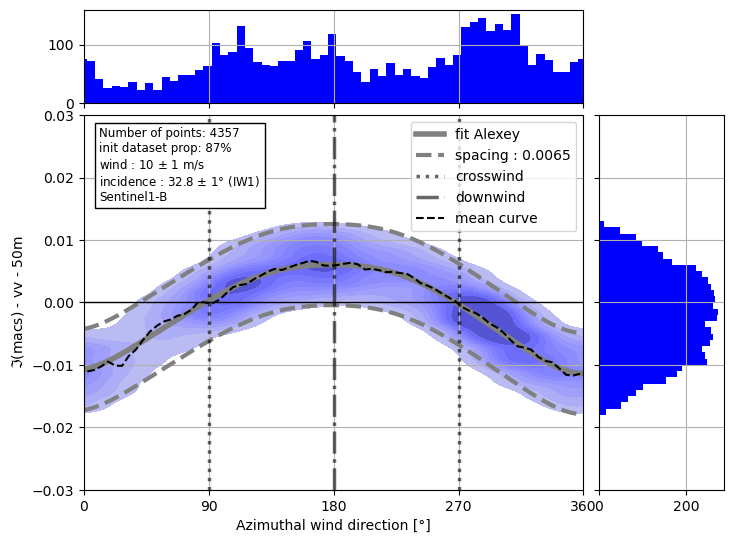

In [21]:
### plot figure ###

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


### Central plot
#ax.scatter(az_wdir_sel ,Imacs_sel, color='blue', label='raw data')
#ax.scatter(az_wdir_ext ,imacs_ext, color='red', alpha=0.4 , label='filtered data')
sns.kdeplot(x=az_wdir_ext, y=imacs_ext, color='blue', fill=True, bw_adjust=.5, ax=ax)

ax.plot(az_wdir_sel.sort_values(), imacs_fit_alexey.reindex(az_wdir_sel.sort_values().index), color='gray', label='fit Alexey', lw=4)     # plot the fit curve
ax.plot(az_wdir_sel.sort_values(), (imacs_fit_alexey + spacing).reindex(az_wdir_sel.sort_values().index) , color='gray', ls='--', lw=3, label='spacing : %.4f' %(spacing))     # plot the + 1.5*std fit curve
ax.plot(az_wdir_sel.sort_values(), (imacs_fit_alexey - spacing).reindex(az_wdir_sel.sort_values().index) , color='gray', ls='--', lw=3)   # plot the - 1.5*std fit curve

ax.hlines(0,-70,420, color='black', lw=1) 
ymax = 0.030; ax.vlines([90,270], -ymax, ymax, color='black', label='crosswind', linestyles="dotted", alpha=0.6, lw=2.5)
ax.vlines(180, -ymax, ymax, color='black', label='downwind', linestyles="dashdot", alpha=0.6, lw=2.5)

ax.set_xticks([0,90,180,270,360])
ax.set_xlim(0,360)
ax.set_ylim(-ymax, ymax)
ax.set_xlabel('Azimuthal wind direction [°]')
ax.set_ylabel('$\Im$(macs) - vv - 50m')
ax.grid()


### density plots 
binwidth = 1

x_bins = np.arange(-70,420 + binwidth, binwidth*6)
ax_histx.hist(az_wdir_ext,bins=x_bins, color='blue')
ax_histx.grid()

y_bins = np.arange(-ymax, ymax , binwidth*ymax/30)
ax_histy.hist(imacs_ext, bins=y_bins, color='blue', orientation='horizontal')
ax_histy.grid()

txt_str = 'Number of points: %d \ninit dataset prop: %d%% \nwind : 10 $\pm$ 1 m/s \nincidence : %.1f $\pm$ 1° (IW1) \nSentinel1-B' %(len(imacs_filt), (len(imacs_filt)/len(Imacs_sel))*100 , mean_iangle_iw1[1])
props = dict(boxstyle = 'square', facecolor = 'white')
ax.text(0.03, 0.97, txt_str, transform = ax.transAxes, fontsize = 8.5, verticalalignment = 'top', bbox = props)

### mean curve calculation
mean_curve_calc(az_wdir_ext, imacs_ext)


ax.legend()
#plt.savefig('/home1/datahome/ljessel/Plots/MACS_analysis/all_S1A/verif_plots_imacs.png')

#### 3.3.2.2) IW2 : 39°

In [22]:
Imacs_sel = macs_Im_tot[1][(inc_tot[1] > mean_iangle_iw2[2]-1) & (inc_tot[1] < mean_iangle_iw2[2]+1)]  # Imacs values selection by wind speed and in a range of 1° around one mean incidence angle
Imacs_sel = Imacs_sel[Imacs_sel !=0].dropna()      # selection of non NaN and non nul values
az_wdir_sel = az_wdir.loc[Imacs_sel.index]         # selection of azimutal direction corresponding to the Imacs values selected 

### Imacs_fit Alexey
imacs_fit_alexey = imacs_fit(mean_iangle_iw2[2], 10, az_wdir_sel) 
imacs_fit_alexey_std = imacs_fit_alexey.std() 

print(mean_iangle_iw2[2])

### Filtering : Selection of Imacs values in a range of Alexey GMF +- 0.0065 
spacing = 0.0065
imacs_filt = Imacs_sel[(Imacs_sel < imacs_fit_alexey + spacing) & (Imacs_sel > imacs_fit_alexey - spacing)]
az_wdir_filt = az_wdir.loc[imacs_filt.index]  # selection of azimutal direction corresponding to the Imacs values selected 


### Dataframe boundaries extension 
# Create a new dataframe to duplicate data from the left (300° --> 0°)
Imacs_before = imacs_filt[az_wdir_filt >= 300]
az_wdir_before = az_wdir_filt[az_wdir_filt >= 300]
az_wdir_before -= 360        # modify the azimutal wind direction to get into the [-60 - 0] range  


# Create a new dataframe to duplicate data from the right (360 --> 60)
Imacs_after = imacs_filt[az_wdir_filt <= 60]
az_wdir_after = az_wdir_filt[az_wdir_filt <= 60]
az_wdir_after += 360         # modify the azimutal wind direction to get into the [360 - 60] range  


# Add the two duplicated datas to the original dataframe
imacs_ext = pd.concat([Imacs_before, imacs_filt, Imacs_after])
az_wdir_ext = pd.concat([az_wdir_before, az_wdir_filt, az_wdir_after])

print(len(imacs_ext), len(Imacs_before), len(Imacs_after), len(imacs_filt), len(Imacs_sel))

38.89059556153846
9734 1565 594 7575 8213


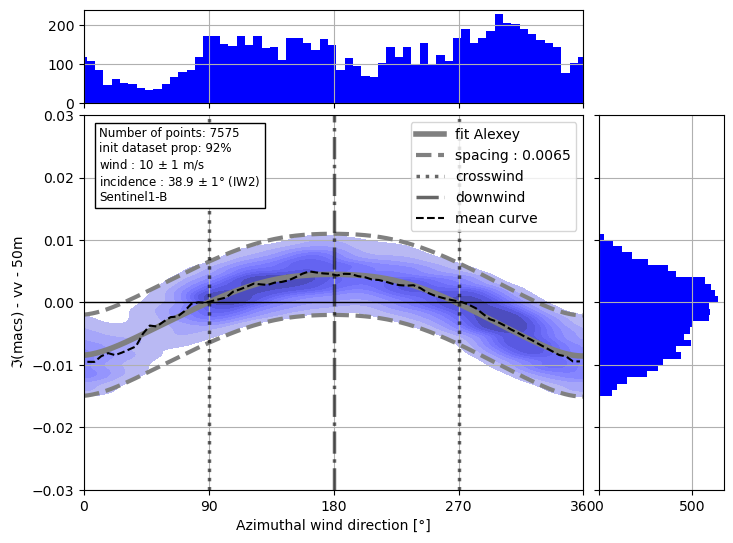

In [24]:
### plot figure ###

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


### Central plot
#ax.scatter(az_wdir_sel ,Imacs_sel, color='blue', label='raw data')
#ax.scatter(az_wdir_ext ,imacs_ext, color='red', alpha=0.4 , label='filtered data')
sns.kdeplot(x=az_wdir_ext, y=imacs_ext, color='blue', fill=True, bw_adjust=.5, ax=ax)

ax.plot(az_wdir_sel.sort_values(), imacs_fit_alexey.reindex(az_wdir_sel.sort_values().index), color='gray', label='fit Alexey', lw=4)     # plot the fit curve
ax.plot(az_wdir_sel.sort_values(), (imacs_fit_alexey + spacing).reindex(az_wdir_sel.sort_values().index) , color='gray', ls='--', lw=3, label='spacing : %.4f' %(spacing))     # plot the + 1.5*std fit curve
ax.plot(az_wdir_sel.sort_values(), (imacs_fit_alexey - spacing).reindex(az_wdir_sel.sort_values().index) , color='gray', ls='--', lw=3)   # plot the - 1.5*std fit curve

ax.hlines(0,-70,420, color='black', lw=1) 
ymax = 0.030
ax.vlines([90,270], -ymax, ymax, color='black', label='crosswind', linestyles="dotted", alpha=0.6, lw=2.5)
ax.vlines(180, -ymax, ymax, color='black', label='downwind', linestyles="dashdot", alpha=0.6, lw=2.5)

ax.set_xticks([0,90,180,270,360])
ax.set_xlim(0,360)
ax.set_ylim(-ymax, ymax)
ax.set_xlabel('Azimuthal wind direction [°]')
ax.set_ylabel('$\Im$(macs) - vv - 50m')
ax.grid()


### density plots 
binwidth = 1

x_bins = np.arange(-70,420 + binwidth, binwidth*6)
ax_histx.hist(az_wdir_ext,bins=x_bins, color='blue')
ax_histx.grid()

y_bins = np.arange(-ymax, ymax , binwidth*ymax/30)
ax_histy.hist(imacs_ext, bins=y_bins, color='blue', orientation='horizontal')
ax_histy.grid()

txt_str = 'Number of points: %d \ninit dataset prop: %d%% \nwind : 10 $\pm$ 1 m/s \nincidence : %.1f $\pm$ 1° (IW2) \nSentinel1-B' %(len(imacs_filt), (len(imacs_filt)/len(Imacs_sel))*100 , mean_iangle_iw2[2])
props = dict(boxstyle = 'square', facecolor = 'white')
ax.text(0.03, 0.97, txt_str, transform = ax.transAxes, fontsize = 8.5, verticalalignment = 'top', bbox = props)

### mean curve calculation
mean_curve_calc(az_wdir_ext, imacs_ext)


ax.legend()
#plt.savefig('/home1/datahome/ljessel/Plots/MACS_analysis/all_S1A/verif_plots_imacs.png')

#### 3.3.2.3) IW3 : 44°

In [25]:
Imacs_sel = macs_Im_tot[1][(inc_tot[1] > mean_iangle_iw3[2]-1) & (inc_tot[1] < mean_iangle_iw3[2]+1)]  # Imacs values selection by wind speed and in a range of 1° around one mean incidence angle
Imacs_sel = Imacs_sel[Imacs_sel !=0].dropna()      # selection of non NaN and non nul values
az_wdir_sel = az_wdir.loc[Imacs_sel.index]         # selection of azimutal direction corresponding to the Imacs values selected 

### Imacs_fit Alexey
imacs_fit_alexey = imacs_fit(mean_iangle_iw3[2], 10, az_wdir_sel) 
imacs_fit_alexey_std = imacs_fit_alexey.std() 

print(mean_iangle_iw3[2])

### Filtering : Selection of Imacs values in a range of Alexey GMF +- 0.0065 
spacing = 0.0065
imacs_filt = Imacs_sel[(Imacs_sel < imacs_fit_alexey + spacing) & (Imacs_sel > imacs_fit_alexey - spacing)]
az_wdir_filt = az_wdir.loc[imacs_filt.index]  # selection of azimutal direction corresponding to the Imacs values selected 


### Dataframe boundaries extension 
# Create a new dataframe to duplicate data from the left (300° --> 0°)
Imacs_before = imacs_filt[az_wdir_filt >= 300]
az_wdir_before = az_wdir_filt[az_wdir_filt >= 300]
az_wdir_before -= 360        # modify the azimutal wind direction to get into the [-60 - 0] range  


# Create a new dataframe to duplicate data from the right (360 --> 60)
Imacs_after = imacs_filt[az_wdir_filt <= 60]
az_wdir_after = az_wdir_filt[az_wdir_filt <= 60]
az_wdir_after += 360         # modify the azimutal wind direction to get into the [360 - 60] range  


# Add the two duplicated datas to the original dataframe
imacs_ext = pd.concat([Imacs_before, imacs_filt, Imacs_after])
az_wdir_ext = pd.concat([az_wdir_before, az_wdir_filt, az_wdir_after])

print(len(imacs_ext), len(Imacs_before), len(Imacs_after), len(imacs_filt), len(Imacs_sel))

44.03936762307693
11006 1724 905 8377 8965


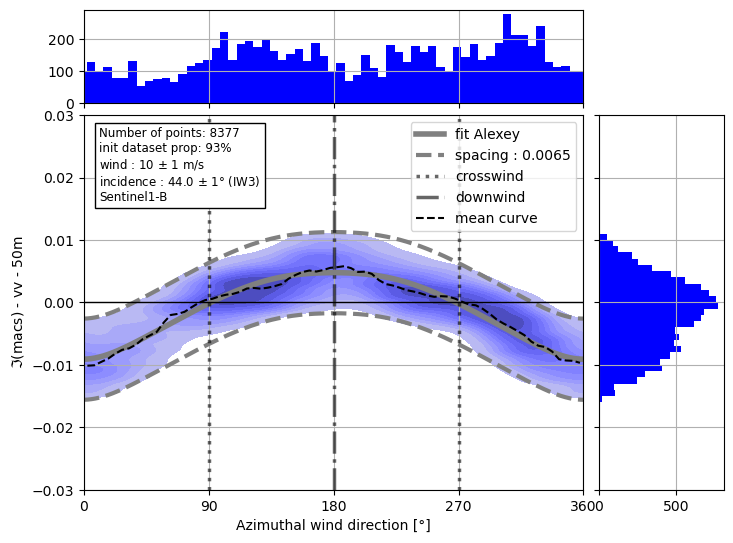

In [29]:
### plot figure ###

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


### Central plot
#ax.scatter(az_wdir_sel ,Imacs_sel, color='blue', label='raw data')
#ax.scatter(az_wdir_ext ,imacs_ext, color='red', alpha=0.4 , label='filtered data')
sns.kdeplot(x=az_wdir_ext, y=imacs_ext, color='blue', fill=True, bw_adjust=.5, ax=ax)

ax.plot(az_wdir_sel.sort_values(), imacs_fit_alexey.reindex(az_wdir_sel.sort_values().index), color='gray', label='fit Alexey', lw=4)     # plot the fit curve
ax.plot(az_wdir_sel.sort_values(), (imacs_fit_alexey + spacing).reindex(az_wdir_sel.sort_values().index) , color='gray', ls='--', lw=3, label='spacing : %.4f' %(spacing))     # plot the + 1.5*std fit curve
ax.plot(az_wdir_sel.sort_values(), (imacs_fit_alexey - spacing).reindex(az_wdir_sel.sort_values().index) , color='gray', ls='--', lw=3)   # plot the - 1.5*std fit curve

ax.hlines(0,-70,420, color='black', lw=1) 
ymax = 0.030
ax.vlines([90,270], -ymax, ymax, color='black', label='crosswind', linestyles="dotted", alpha=0.6, lw=2.5)
ax.vlines(180, -ymax, ymax, color='black', label='downwind', linestyles="dashdot", alpha=0.6, lw=2.5)

ax.set_xticks([0,90,180,270,360])
ax.set_xlim(0,360)
ax.set_ylim(-ymax, ymax)
ax.set_xlabel('Azimuthal wind direction [°]')
ax.set_ylabel('$\Im$(macs) - vv - 50m')
ax.grid()


### density plots 
binwidth = 1

x_bins = np.arange(-70,420 + binwidth, binwidth*6)
ax_histx.hist(az_wdir_ext,bins=x_bins, color='blue')
ax_histx.grid()

y_bins = np.arange(-ymax, ymax , binwidth*ymax/30)
ax_histy.hist(imacs_ext, bins=y_bins, color='blue', orientation='horizontal')
ax_histy.grid()

txt_str = 'Number of points: %d \ninit dataset prop: %d%% \nwind : 10 $\pm$ 1 m/s \nincidence : %.1f $\pm$ 1° (IW3) \nSentinel1-B' %(len(imacs_filt), (len(imacs_filt)/len(Imacs_sel))*100 , mean_iangle_iw3[2])
props = dict(boxstyle = 'square', facecolor = 'white')
ax.text(0.03, 0.97, txt_str, transform = ax.transAxes, fontsize = 8.5, verticalalignment = 'top', bbox = props)

### mean curve calculation
mean_curve_calc(az_wdir_ext, imacs_ext)


ax.legend()
#plt.savefig('/home1/datahome/ljessel/Plots/MACS_analysis/all_S1A/verif_plots_imacs.png')

### 5m/s & 44° inc 

### 3.3.2) 10m/s

In [64]:
Imacs_sel = macs_Im_tot[0][(inc_tot[0] > mean_iangle_iw3[2]-1) & (inc_tot[0] < mean_iangle_iw3[2]+1)].dropna()  # selection of a range of 1° around one mean incidence angle and without NaN values
Imacs_sel = Imacs_sel[Imacs_sel !=0]        # selection of non nul values, len(b), len(Imacs_sel) - len(a))
az_wdir_sel = az_wdir.loc[Imacs_sel.index]  # selection of azimutal direction corresponding to the Imacs values selected 


# Create a new dataframe to duplicate data from the left (300 --> 0)
Imacs_before = Imacs_sel[az_wdir_sel >= 300]
az_wdir_before = az_wdir_sel[az_wdir_sel >= 300]
az_wdir_before -= 360        # modify the azimutal wind direction to get into the [-60 - 0] range  


# Create a new dataframe to duplicate data from the right (360 --> 60)
Imacs_after = Imacs_sel[az_wdir_sel <= 60].copy()
az_wdir_after = az_wdir_sel[az_wdir_sel <= 60]
az_wdir_after += 360         # modify the azimutal wind direction to get into the [360 - 60] range  


# Add the two duplicated datas to the original dataframe
imacs_ext = pd.concat([Imacs_before, Imacs_sel, Imacs_after])
az_wdir_ext = pd.concat([az_wdir_before, az_wdir_sel, az_wdir_after])

print(len(imacs_ext), len(Imacs_before), len(Imacs_after), len(Imacs_sel))

30202 3918 3615 22669


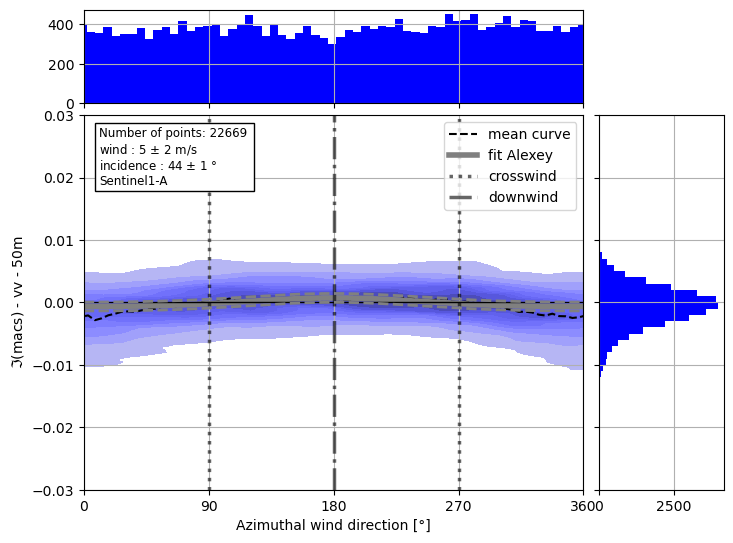

In [65]:
### plot figure ###

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

#ax.scatter(az_wdir_ext ,imacs_ext, color='blue', label='Sentinel-1A')
sns.kdeplot(x=az_wdir_ext, y=imacs_ext, color='blue', fill=True, bw_adjust=.5, ax=ax)
ymax = 0.030
ax.set_xticks([0,90,180,270,360])
ax.set_xlim(0,360)
ax.set_ylim(-ymax, ymax)
ax.set_xlabel('Azimuthal wind direction [°]')
ax.set_ylabel('$\Im$(macs) - vv - 50m')
ax.grid()


### density plots 
binwidth = 1

x_bins = np.arange(-70,420 + binwidth, binwidth*6)
ax_histx.hist(az_wdir_ext,bins=x_bins, color='blue')
ax_histx.grid()

y_bins = np.arange(-ymax, ymax , binwidth*ymax/30)
ax_histy.hist(imacs_ext, bins=y_bins, color='blue', orientation='horizontal')
ax_histy.grid()

txt_str = 'Number of points: %d \nwind : 5 $\pm$ 2 m/s \nincidence : %d $\pm$ 1 ° \nSentinel1-A' % (len(Imacs_sel), float(mean_iangle_iw3[2]))
props = dict(boxstyle = 'square', facecolor = 'white')
ax.text(0.03, 0.97, txt_str, transform = ax.transAxes, fontsize = 8.5, verticalalignment = 'top', bbox = props)


### mean curve calculation
az_wdir_sel_mean = np.linspace(min(az_wdir_ext), max(az_wdir_ext), 100) # settings points for the mean curve
Imacs_mean = np.zeros_like(az_wdir_sel_mean)                            # Initialise mean s0 values
bin_edges = np.linspace(min(az_wdir_ext), max(az_wdir_ext), 100)        # discretize the data in 100 bins 
for i in range(len(bin_edges) - 1):
    mask = (az_wdir_ext >= bin_edges[i]) & (az_wdir_ext < bin_edges[i+1])     # Mask to selects the points in the bin
    Imacs_mean[i] = np.mean(imacs_ext[mask]) if np.sum(mask) > 0 else np.nan  # Calculation of the Imacs mean value in the bin
ax.plot(az_wdir_sel_mean, Imacs_mean, color='black', label='mean curve', linestyle='--' )     # plot the mean curve


### Alexey fit curve 
def imacs_fit(alpha, u, phi):    # alpha: incidence angle, u: wind speed, phi: azimuth
    alpha = np.deg2rad(alpha)
    phi = np.deg2rad(phi)
    fit = ((0.07271781 / np.sin(np.sinc(np.exp(1/alpha)) + alpha)) *
           ((np.cos(phi - ((np.sinc(np.tan(alpha)) * np.sin(u ** 0.7317495)) / np.exp(phi))) *
             (4.593332 - (u + np.tan((np.cos(phi) * np.sin(0.4504337 - np.sin(u / np.exp(np.cos(alpha)))))
                                     +  0.18788569)))) - 0.17755319))
    return fit/100

#imacs_fit_alexey = imacs_fit(inc_tot[2].loc[az_wdir_ext.index], wnd_spd_15ms.loc[az_wdir_ext.index], az_wdir_ext.sort_values()) 
imacs_fit_alexey = imacs_fit(mean_iangle_iw3[2], 5, az_wdir_ext.sort_values()) 
ax.plot(az_wdir_ext.sort_values(), imacs_fit_alexey, color='gray', label='fit Alexey', lw=4)     # plot the fit curve

ax.hlines(0,-70,420, color='black', lw=1) 
ax.vlines([90,270], -ymax, ymax, color='black', label='crosswind', linestyles="dotted", alpha=0.6, lw=2.5)
#ax.vlines([0,360], -ymax, ymax, color='black', label='upwind', alpha=0.6, lw=2.5)
ax.vlines(180, -ymax, ymax, color='black', label='downwind', linestyles="dashdot", alpha=0.6, lw=2.5)

imacs_fit_alexey_std = imacs_fit_alexey.std() 
ax.plot(az_wdir_ext.sort_values(), imacs_fit_alexey + 1.5*imacs_fit_alexey_std , color='gray', ls='--', lw=2)     # plot the fit curve
ax.plot(az_wdir_ext.sort_values(), imacs_fit_alexey - 1.5*imacs_fit_alexey_std , color='gray', ls='--', lw=2)

ax.legend()
#plt.savefig('/home1/datahome/ljessel/Plots/MACS_analysis/all_S1A/verif_plots_imacs.png')

### 15m/s & 43° inc 

In [67]:
Imacs_sel = macs_Im_tot[2][(inc_tot[2] > mean_iangle_iw3[1]-1) & (inc_tot[2] < mean_iangle_iw3[1]+1)].dropna()  # selection of a range of 1° around one mean incidence angle and without NaN values
Imacs_sel = Imacs_sel[Imacs_sel !=0]        # selection of non nul values, len(b), len(Imacs_sel) - len(a))
az_wdir_sel = az_wdir.loc[Imacs_sel.index]  # selection of azimutal direction corresponding to the Imacs values selected 


# Create a new dataframe to duplicate data from the left (300 --> 0)
Imacs_before = Imacs_sel[az_wdir_sel >= 300]
az_wdir_before = az_wdir_sel[az_wdir_sel >= 300]
az_wdir_before -= 360        # modify the azimutal wind direction to get into the [-60 - 0] range  


# Create a new dataframe to duplicate data from the right (360 --> 60)
Imacs_after = Imacs_sel[az_wdir_sel <= 60].copy()
az_wdir_after = az_wdir_sel[az_wdir_sel <= 60]
az_wdir_after += 360         # modify the azimutal wind direction to get into the [360 - 60] range  


# Add the two duplicated datas to the original dataframe
imacs_ext = pd.concat([Imacs_before, Imacs_sel, Imacs_after])
az_wdir_ext = pd.concat([az_wdir_before, az_wdir_sel, az_wdir_after])

print(len(imacs_ext), len(Imacs_before), len(Imacs_after), len(Imacs_sel))

7493 905 768 5820


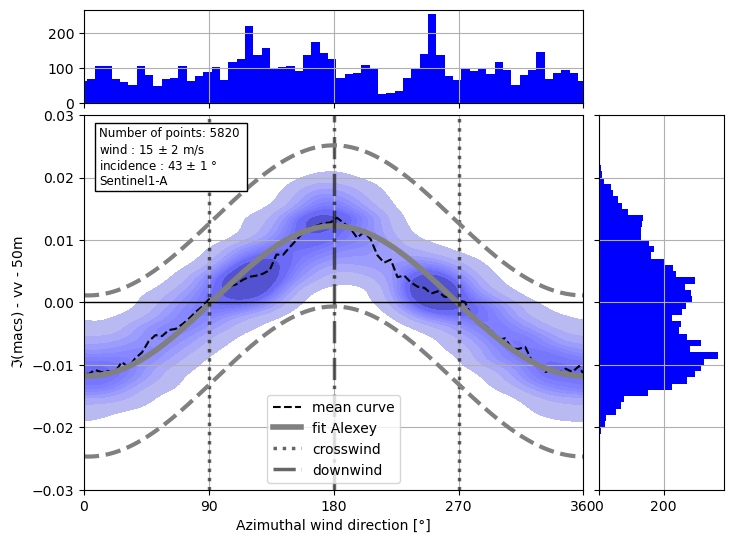

In [68]:
### plot figure ###

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)

# no labels
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

#ax.scatter(az_wdir_ext ,imacs_ext, color='blue', label='Sentinel-1A')
sns.kdeplot(x=az_wdir_ext, y=imacs_ext, color='blue', fill=True, bw_adjust=.5, ax=ax)
ymax = 0.030
ax.set_xticks([0,90,180,270,360])
ax.set_xlim(0,360)
ax.set_ylim(-ymax, ymax)
ax.set_xlabel('Azimuthal wind direction [°]')
ax.set_ylabel('$\Im$(macs) - vv - 50m')
ax.grid()


### density plots 
binwidth = 1

x_bins = np.arange(-70,420 + binwidth, binwidth*6)
ax_histx.hist(az_wdir_ext,bins=x_bins, color='blue')
ax_histx.grid()

y_bins = np.arange(-ymax, ymax , binwidth*ymax/30)
ax_histy.hist(imacs_ext, bins=y_bins, color='blue', orientation='horizontal')
ax_histy.grid()

txt_str = 'Number of points: %d \nwind : 15 $\pm$ 2 m/s \nincidence : %d $\pm$ 1 ° \nSentinel1-A' % (len(Imacs_sel), float(mean_iangle_iw3[1]))
props = dict(boxstyle = 'square', facecolor = 'white')
ax.text(0.03, 0.97, txt_str, transform = ax.transAxes, fontsize = 8.5, verticalalignment = 'top', bbox = props)


### mean curve calculation
az_wdir_sel_mean = np.linspace(min(az_wdir_ext), max(az_wdir_ext), 100) # settings points for the mean curve
Imacs_mean = np.zeros_like(az_wdir_sel_mean)                            # Initialise mean s0 values
bin_edges = np.linspace(min(az_wdir_ext), max(az_wdir_ext), 100)        # discretize the data in 100 bins 
for i in range(len(bin_edges) - 1):
    mask = (az_wdir_ext >= bin_edges[i]) & (az_wdir_ext < bin_edges[i+1])     # Mask to selects the points in the bin
    Imacs_mean[i] = np.mean(imacs_ext[mask]) if np.sum(mask) > 0 else np.nan  # Calculation of the Imacs mean value in the bin
ax.plot(az_wdir_sel_mean, Imacs_mean, color='black', label='mean curve', linestyle='--' )     # plot the mean curve


### Alexey fit curve 
def imacs_fit(alpha, u, phi):    # alpha: incidence angle, u: wind speed, phi: azimuth
    alpha = np.deg2rad(alpha)
    phi = np.deg2rad(phi)
    fit = ((0.07271781 / np.sin(np.sinc(np.exp(1/alpha)) + alpha)) *
           ((np.cos(phi - ((np.sinc(np.tan(alpha)) * np.sin(u ** 0.7317495)) / np.exp(phi))) *
             (4.593332 - (u + np.tan((np.cos(phi) * np.sin(0.4504337 - np.sin(u / np.exp(np.cos(alpha)))))
                                     +  0.18788569)))) - 0.17755319))
    return fit/100

#imacs_fit_alexey = imacs_fit(inc_tot[2].loc[az_wdir_ext.index], wnd_spd_15ms.loc[az_wdir_ext.index], az_wdir_ext.sort_values()) 
imacs_fit_alexey = imacs_fit(mean_iangle_iw3[1], 15, az_wdir_ext.sort_values()) 
ax.plot(az_wdir_ext.sort_values(), imacs_fit_alexey, color='gray', label='fit Alexey', lw=4)     # plot the fit curve

ax.hlines(0,-70,420, color='black', lw=1) 
ax.vlines([90,270], -ymax, ymax, color='black', label='crosswind', linestyles="dotted", alpha=0.6, lw=2.5)
#ax.vlines([0,360], -ymax, ymax, color='black', label='upwind', alpha=0.6, lw=2.5)
ax.vlines(180, -ymax, ymax, color='black', label='downwind', linestyles="dashdot", alpha=0.6, lw=2.5)

imacs_fit_alexey_std = imacs_fit_alexey.std() 
ax.plot(az_wdir_ext.sort_values(), imacs_fit_alexey + 1.5*imacs_fit_alexey_std , color='gray', ls='--', lw=3)     # plot the fit curve
ax.plot(az_wdir_ext.sort_values(), imacs_fit_alexey - 1.5*imacs_fit_alexey_std , color='gray', ls='--', lw=3)

ax.legend()
#plt.savefig('/home1/datahome/ljessel/Plots/MACS_analysis/all_S1A/verif_plots_imacs.png')